In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
from baseline_utils import generate_grid_coordinates, generate_grid_values_from_sourceloc, generate_sourceloc_from_coordinates, add_anomaly
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers
from keras.models import Model
#from tensorflow.keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.datasets import mnist
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from tensorflow.keras.layers import Dense, Input, Flatten,Reshape, LeakyReLU as LR,Activation, Dropout
from tensorflow.keras.models import Model, Sequential
import argparse
import os
from autoencoder_model import autoencoder_model
from cnn_model import cnn_model
from mean_reconstruction import mean_reconstruction
from plot_grid import plot_grid
plt.rcParams["figure.figsize"] = (13,7)

In [7]:
test_sample = np.load('test_sample_obadah.npy')
size = 100

In [6]:
def plot_grid(source_locations,array,size):
    arr = np.copy(array) 
    fig, ax = plt.subplots()
    ax.grid(which='major', color='black', linestyle='-', linewidth=1)
    # To display the values
    ax.set_xlim([0,size**2])
    ax.set_ylim([0,size**2])
    for [i,j], z in zip(source_locations,arr.ravel()):
        ax.text(i+0.5, j+0.5, '{:0.1f}'.format(z), ha='center', va='center')
    plt.xticks(np.arange(0, size**2, size))
    plt.yticks(np.arange(0, size**2, size))
    plt.show()
    
def generate_grid_coordinates(size):
    grid_coordinates = np.zeros((size,size,2))
    for i in range(size):
        for j in range(size):
            grid_coordinates[i][j][0] = ((i+1) * size) - size/2
            grid_coordinates[i][j][1] = ((j+1) * size) - size/2
    return grid_coordinates

In [8]:
grid_coordinates = generate_grid_coordinates(size) ## generate sensor locations for training (each sensor placed at center of each grid)
sensor_locations = grid_coordinates.reshape(size**2, 2) ## sensor locations

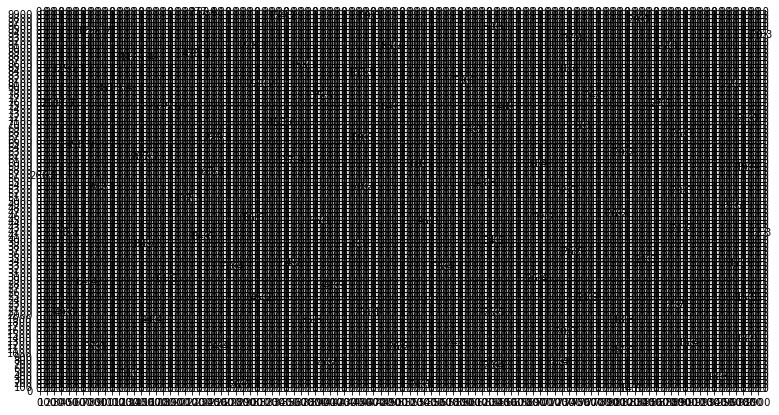

In [12]:
plot_grid(sensor_locations, test_sample[0], size)

In [14]:
zero_loc = np.where(test_sample[0] == 0)

In [19]:
zero_loc[0]

array([ 0,  0,  0, ..., 99, 99, 99], dtype=int64)

In [17]:
test_sample[0].shape

(100, 100)

In [20]:
np.count_nonzero(test_sample[0]==0)

9900

In [21]:
t1 = test_sample[0]

In [25]:
t1[t1==0] = np.nan

In [26]:
window_size = 10
while(np.isnan(t1).any()):
    t1 = mean_reconstruction(t1, window_size)
    window_size += 1

D:\Shahmir Thesis Code\Python Code\mean_reconstruction.py:11: RuntimeWarning: Mean of empty slice
  window = np.nan_to_num(window, nan=np.nanmean(window))


In [27]:
t1

array([[ 37.79299927,  37.79299927,  37.79299927, ..., 623.96726996,
        637.40620899, 647.39763182],
       [ 37.79299927,  37.79299927,  37.79299927, ..., 623.96726996,
        637.40620899, 647.39763182],
       [ 37.79299927,  37.79299927,  37.79299927, ..., 623.96726996,
        637.40620899, 647.39763182],
       ...,
       [ 35.21120038,  35.21120038,  35.21120038, ...,  39.36281418,
         39.50553532,  39.65120227],
       [ 35.17162007,  35.17162007,  35.17162007, ...,  39.20960928,
         39.35179544,  39.49667666],
       [ 35.13291711,  35.13291711,  35.13291711, ...,  38.86986239,
         39.01014372,  39.15297848]])

In [28]:
    print("Loading pretrained models")
    autoencoder = load_model("saved_models/cdae_pretrained", custom_objects=None,compile=True)
    cnn = load_model("saved_models/cnn_pretrained")
    print("Pretrained models successfully loaded")

Loading pretrained models
Pretrained models successfully loaded


In [29]:
test_autoencoder_output = autoencoder.predict(t1.reshape(1, size, size, 1))

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step
Predicted source location:  (array([29], dtype=int64), array([30], dtype=int64))


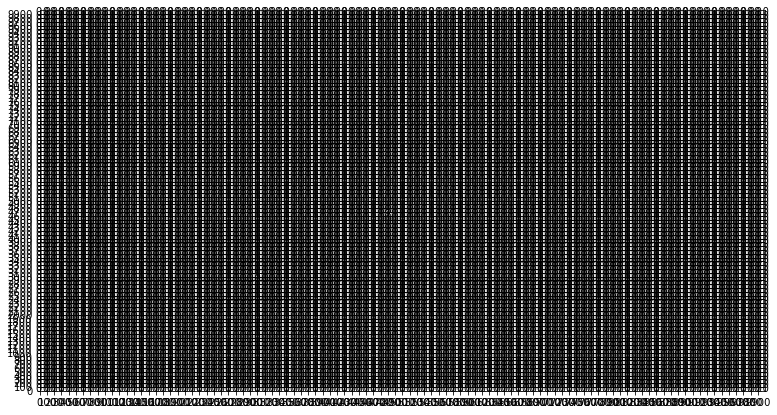

In [30]:
    test_cnn_output = cnn.predict(test_autoencoder_output)
    pred = test_cnn_output.reshape(size,size)
    print("Predicted source location: ", np.where(pred == np.amax(pred)))
    plot_grid(sensor_locations, test_cnn_output[0], size)

In [43]:
np.argmax(test_autoencoder_output.reshape(100,100))

9700

In [41]:
test_autoencoder_output.shape

(1, 100, 100, 1)

In [42]:
test_autoencoder_output.reshape(100,100)[3][83]

1.0646574e-14

In [55]:
test_autoencoder_output.shape

(1, 100, 100, 1)

In [57]:
np.where(t1 == np.amax(t1))

(array([3], dtype=int64), array([84], dtype=int64))

In [62]:
np.where(test_sample[1] == np.amax(test_sample[1]))

(array([93], dtype=int64), array([3], dtype=int64))

In [ ]:
print("Loading pretrained models")
autoencoder = load_model("saved_models/cdae_pretrained", custom_objects=None,compile=True)
cnn = load_model("saved_models/cnn_pretrained")
print("Pretrained models successfully loaded") 

In [72]:
loc_error = 0
for samples in np.copy(test_sample):
    window_size = 10
    source_loc = np.where(samples == np.amax(samples))
    samples[samples==0] = np.nan
    while(np.isnan(samples).any()):
        samples = mean_reconstruction(samples, window_size)
        window_size += 1
    
    
    test_autoencoder_output = autoencoder.predict(samples.reshape(1, size, size, 1))
    test_cnn_output = cnn.predict(test_autoencoder_output)
    pred = test_cnn_output.reshape(size,size)
    print("Predicted source location: ", np.where(pred == np.amax(pred)))
    print("Actual source location: ", source_loc)
    print("Localization Error: ", math.dist(source_loc, np.where(pred == np.amax(pred))))
    loc_error += math.dist(source_loc, np.where(pred == np.amax(pred)))

print("The average localization error is: ", loc_error/100)
    

Loading pretrained models
Pretrained models successfully loaded
1/1 [==============================] - 0s 252ms/step
Predicted source location:  (array([29], dtype=int64), array([30], dtype=int64))
Actual source location:  (array([3], dtype=int64), array([84], dtype=int64))
Localization Error:  59.93329625508679
1/1 [==============================] - 0s 161ms/step
Predicted source location:  (array([60], dtype=int64), array([44], dtype=int64))
Actual source location:  (array([93], dtype=int64), array([3], dtype=int64))
Localization Error:  52.630789467763066


D:\Shahmir Thesis Code\Python Code\mean_reconstruction.py:11: RuntimeWarning: Mean of empty slice
  window = np.nan_to_num(window, nan=np.nanmean(window))


1/1 [==============================] - 0s 172ms/step
Predicted source location:  (array([29], dtype=int64), array([30], dtype=int64))
Actual source location:  (array([33], dtype=int64), array([70], dtype=int64))
Localization Error:  40.19950248448356
1/1 [==============================] - 0s 157ms/step
Predicted source location:  (array([39], dtype=int64), array([91], dtype=int64))
Actual source location:  (array([7], dtype=int64), array([11], dtype=int64))
Localization Error:  86.16263691415207
1/1 [==============================] - 0s 142ms/step
Predicted source location:  (array([29], dtype=int64), array([30], dtype=int64))
Actual source location:  (array([29], dtype=int64), array([90], dtype=int64))
Localization Error:  60.0
1/1 [==============================] - 0s 141ms/step
Predicted source location:  (array([29], dtype=int64), array([30], dtype=int64))
Actual source location:  (array([83], dtype=int64), array([34], dtype=int64))
Localization Error:  54.147945482723536
1/1 [====

1/1 [==============================] - 0s 127ms/step
Predicted source location:  (array([47], dtype=int64), array([46], dtype=int64))
Actual source location:  (array([39], dtype=int64), array([7], dtype=int64))
Localization Error:  39.81205847478877
1/1 [==============================] - 0s 179ms/step
Predicted source location:  (array([5], dtype=int64), array([18], dtype=int64))
Actual source location:  (array([53], dtype=int64), array([44], dtype=int64))
Localization Error:  54.58937625582472
1/1 [==============================] - 0s 122ms/step
Predicted source location:  (array([78], dtype=int64), array([94], dtype=int64))
Actual source location:  (array([97], dtype=int64), array([71], dtype=int64))
Localization Error:  29.832867780352593
1/1 [==============================] - 0s 131ms/step
Predicted source location:  (array([29], dtype=int64), array([30], dtype=int64))
Actual source location:  (array([13], dtype=int64), array([87], dtype=int64))
Localization Error:  59.203040462462

1/1 [==============================] - 0s 119ms/step
Predicted source location:  (array([78], dtype=int64), array([94], dtype=int64))
Actual source location:  (array([68], dtype=int64), array([29], dtype=int64))
Localization Error:  65.76473218982952
1/1 [==============================] - 0s 119ms/step
Predicted source location:  (array([57], dtype=int64), array([25], dtype=int64))
Actual source location:  (array([80], dtype=int64), array([10], dtype=int64))
Localization Error:  27.459060435491963
1/1 [==============================] - 0s 128ms/step
Predicted source location:  (array([57], dtype=int64), array([25], dtype=int64))
Actual source location:  (array([44], dtype=int64), array([53], dtype=int64))
Localization Error:  30.870698080866262
1/1 [==============================] - 0s 118ms/step
Predicted source location:  (array([29], dtype=int64), array([30], dtype=int64))
Actual source location:  (array([13], dtype=int64), array([87], dtype=int64))
Localization Error:  59.203040462

1/1 [==============================] - 0s 151ms/step
Predicted source location:  (array([47], dtype=int64), array([46], dtype=int64))
Actual source location:  (array([39], dtype=int64), array([7], dtype=int64))
Localization Error:  39.81205847478877
1/1 [==============================] - 0s 148ms/step
Predicted source location:  (array([5], dtype=int64), array([18], dtype=int64))
Actual source location:  (array([24], dtype=int64), array([11], dtype=int64))
Localization Error:  20.248456731316587
1/1 [==============================] - 0s 131ms/step
Predicted source location:  (array([47], dtype=int64), array([46], dtype=int64))
Actual source location:  (array([34], dtype=int64), array([33], dtype=int64))
Localization Error:  18.38477631085024
1/1 [==============================] - 0s 144ms/step
Predicted source location:  (array([52], dtype=int64), array([2], dtype=int64))
Actual source location:  (array([74], dtype=int64), array([69], dtype=int64))
Localization Error:  70.5195008490559

In [71]:
np.where(test_sample[3] == np.amax(test_sample[3]))

(array([7], dtype=int64), array([11], dtype=int64))

In [66]:
samples

array([[46.43241119, 46.43241119, 46.43241119, ..., 62.64461447,
        62.83744976, 63.02546111],
       [46.43241119, 46.43241119, 46.43241119, ..., 62.64461447,
        62.83744976, 63.02546111],
       [46.43241119, 46.43241119, 46.43241119, ..., 62.64461447,
        62.83744976, 63.02546111],
       ...,
       [45.1630593 , 45.1630593 , 45.1630593 , ..., 74.13761664,
        76.45309726, 79.02525292],
       [45.12752677, 45.12752677, 45.12752677, ..., 72.35528327,
        74.47620407, 76.83178559],
       [45.09258905, 45.09258905, 45.09258905, ..., 70.50949084,
        72.4528962 , 74.61035274]])

In [27]:
    size = 100
    source_intensity = 10000000
    detector_area = 0.02
    efficiency = 1
    print("Initializing test aoi with 200 sensors")
    test_source_location = np.random.rand(1, 2) * (size**2)
    print("Source Location: ", test_source_location)
    test_sensor_locations = np.random.rand(200, 2) * (size**2)
    print(test_sensor_locations.shape)
    test_aoi = np.empty([size,size])
    for loc in test_sensor_locations:
        i = int(loc[0] / 100)
        j = int(loc[1] / 100)
        test_aoi[i][j] = (source_intensity * detector_area * efficiency) / (math.dist(loc, test_source_location.reshape(2))**2)
        
    ## Mean reconstruction
    window_size = 10
    while(np.isnan(test_aoi).any()):
        test_aoi = mean_reconstruction(test_aoi, window_size)
        window_size += 1
        
    print("Loading pretrained models")
    autoencoder = load_model("saved_models/cdae_pretrained", custom_objects=None,compile=True)
    cnn = load_model("saved_models/cnn_pretrained")
    print("Pretrained models successfully loaded")
    
    ## Anomaly correction using pretrained autoencoder
    test_autoencoder_output = autoencoder.predict(test_aoi.reshape(1, size, size, 1))
    
    ## Threshold setting
    
    
    ## Localization using pretrained CNN
    test_cnn_output = cnn.predict(test_autoencoder_output)
    pred = test_cnn_output.reshape(size,size)
    print("Predicted source location: ", np.where(pred == np.amax(pred)))
    plot_grid(sensor_locations, test_cnn_output[0], size)
    

Initializing test aoi with 200 sensors
Source Location:  [[1459.55483209  922.02876598]]
(200, 2)
Loading pretrained models
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\kshah\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\kshah\AppData\Local\Temp\ipykernel_6920\2722009036.py", line 23, in <module>
    autoencoder = load_model("saved_models/cdae_pretrained", custom_objects=None,compile=True)
  File "C:\Users\kshah\AppData\Roaming\Python\Python39\site-packages\keras\engine\saving.py", line 492, in load_wrapper
  File "C:\Users\kshah\AppData\Roaming\Python\Python39\site-packages\keras\engine\saving.py", line 583, in load_model
  File "C:\Users\kshah\AppData\Roaming\Python\Python39\site-packages\keras\utils\io_utils.py", line 191, in __init__
  File "C:\Users\kshah\.conda\envs\tf\lib\site-packages\h5py\_hl\files.py", line 507, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "C:\Users\kshah\.conda\envs\tf\lib\site-packages\h5py\_hl\files.py", line 220,

In [9]:
import keras

In [10]:
keras.layers

<module 'keras.layers' from 'C:\\Users\\kshah\\AppData\\Roaming\\Python\\Python39\\site-packages\\keras\\layers\\__init__.py'>

In [11]:
keras.models


<module 'keras.models' from 'C:\\Users\\kshah\\AppData\\Roaming\\Python\\Python39\\site-packages\\keras\\models.py'>

In [12]:
keras.engine

<module 'keras.engine' from 'C:\\Users\\kshah\\AppData\\Roaming\\Python\\Python39\\site-packages\\keras\\engine\\__init__.py'>

In [13]:
keras.models.load_model

<function keras.engine.saving.load_model(filepath, custom_objects=None, compile=True)>

In [14]:
keras.utils

<module 'keras.utils' from 'C:\\Users\\kshah\\AppData\\Roaming\\Python\\Python39\\site-packages\\keras\\utils\\__init__.py'>